<a href="https://colab.research.google.com/github/Dhanraj7573/Python-Projects/blob/main/Risk_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install requests matplotlib



=== Risk Dashboard (Day 1) ===
Symbol: aapl.us
Observations (returns): 10433
Total return (period): 277842.04%
Latest 20D ann. volatility (log returns): 24.88%
Max drawdown: -82.24%
Max drawdown duration: 2129 days

Worst 5 daily returns:
  2000-09-29 : -51.85%
  1987-10-19 : -24.38%
  1993-07-16 : -23.08%
  1987-10-26 : -21.14%
  2008-09-29 : -17.91%


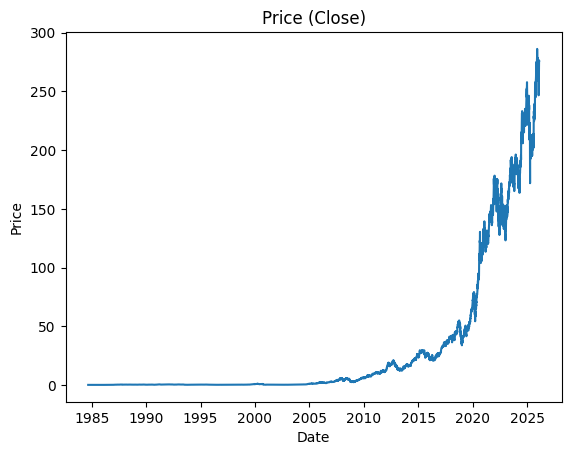

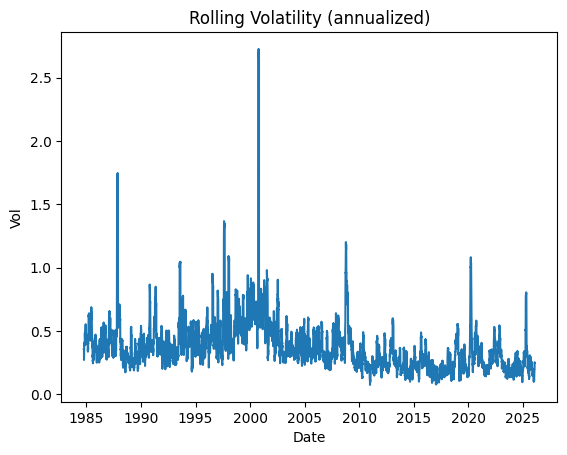

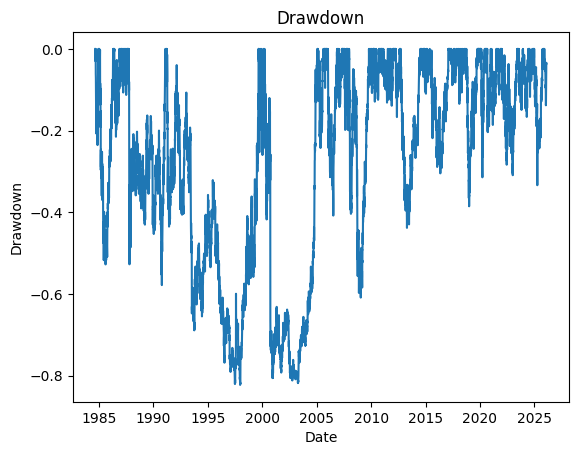

In [2]:
import csv
import io
import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import requests


def fetch_stooq_daily_close(symbol: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fetch daily OHLCV from Stooq and return (dates, close_prices).
    - dates: np.ndarray dtype='datetime64[D]'
    - close_prices: np.ndarray dtype=float
    Example symbols:
      - 'aapl.us', 'msft.us', 'tsla.us'
      - 'xauusd' (gold), 'eurusd' (forex)
    """
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}&i=d"
    r = requests.get(url, timeout=20)
    r.raise_for_status()

    # Parse CSV
    f = io.StringIO(r.text)
    reader = csv.DictReader(f)
    dates = []
    closes = []

    for row in reader:
        # Stooq columns are usually: Date, Open, High, Low, Close, Volume
        d = row.get("Date")
        c = row.get("Close")
        if not d or not c:
            continue
        dates.append(d)
        closes.append(float(c))

    if len(closes) < 5:
        raise ValueError(
            f"Not enough data returned for symbol='{symbol}'. "
            f"Try another (e.g., 'aapl.us') or check spelling."
        )

    dates = np.array(dates, dtype="datetime64[D]")
    closes = np.array(closes, dtype=float)

    # Stooq often returns newest -> oldest; ensure oldest -> newest for time series math
    if dates[0] > dates[-1]:
        dates = dates[::-1]
        closes = closes[::-1]

    return dates, closes


# ----------------------------
# Risk metrics
# ----------------------------
def simple_returns(prices: np.ndarray) -> np.ndarray:
    """r_t = P_t / P_{t-1} - 1"""
    return prices[1:] / prices[:-1] - 1.0


def log_returns(prices: np.ndarray) -> np.ndarray:
    """lr_t = ln(P_t / P_{t-1})"""
    return np.log(prices[1:] / prices[:-1])


def equity_curve(returns: np.ndarray, start: float = 1.0) -> np.ndarray:
    """Equity curve from returns: start * cumprod(1 + r)"""
    return start * np.cumprod(1.0 + returns)


def rolling_volatility(returns: np.ndarray, window: int = 20, annualize: bool = True) -> np.ndarray:
    """
    Rolling standard deviation of returns.
    Returns an array of length len(returns) with NaN for the first (window-1) entries.
    """
    out = np.full_like(returns, np.nan, dtype=float)
    if len(returns) < window:
        return out

    # Use sliding windows (NumPy >= 1.20)
    windows = np.lib.stride_tricks.sliding_window_view(returns, window_shape=window)
    vol = windows.std(axis=1, ddof=1)  # sample std
    if annualize:
        vol *= math.sqrt(252)  # trading days/year

    out[window - 1 :] = vol
    return out


def drawdown_from_equity(eq: np.ndarray) -> np.ndarray:
    """Drawdown series: eq / running_max(eq) - 1"""
    running_max = np.maximum.accumulate(eq)
    return eq / running_max - 1.0


def max_drawdown(dd: np.ndarray) -> float:
    """Max drawdown is the minimum value of drawdown (most negative)."""
    return float(np.min(dd))


def max_drawdown_duration(dd: np.ndarray) -> int:
    """
    Longest consecutive number of days spent below 0 drawdown.
    (Simple and readable loop; fine for this project.)
    """
    best = 0
    cur = 0
    for x in dd:
        if x < 0:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return best


def worst_losses(returns: np.ndarray, dates_for_returns: np.ndarray, n: int = 5):
    """
    Return the worst n daily returns and corresponding dates.
    dates_for_returns should align with returns (i.e., dates[1:]).
    """
    idx = np.argsort(returns)[:n]  # most negative first
    return dates_for_returns[idx], returns[idx]


@dataclass
class Summary:
    symbol: str
    n_days: int
    total_return: float
    ann_vol_20d_latest: float
    max_dd: float
    max_dd_duration_days: int


def summarize(symbol: str, dates: np.ndarray, prices: np.ndarray, vol_window: int = 20) -> Summary:
    r = simple_returns(prices)
    eq = equity_curve(r, start=1.0)
    dd = drawdown_from_equity(eq)
    vol = rolling_volatility(log_returns(prices), window=vol_window, annualize=True)

    total_ret = float(eq[-1] - 1.0)
    latest_vol = float(vol[~np.isnan(vol)][-1]) if np.any(~np.isnan(vol)) else float("nan")

    return Summary(
        symbol=symbol,
        n_days=int(len(r)),
        total_return=total_ret,
        ann_vol_20d_latest=latest_vol,
        max_dd=max_drawdown(dd),
        max_dd_duration_days=max_drawdown_duration(dd),
    )


# ----------------------------
# Optional plotting
# ----------------------------
def plot_basic(dates: np.ndarray, prices: np.ndarray, vol: np.ndarray, dd: np.ndarray):
    import matplotlib.pyplot as plt

    # Align x-axes:
    # prices has len N with dates len N
    # returns/vol/dd use dates[1:] in many calculations; dd is based on equity which matches returns length
    d_ret = dates[1:]

    plt.figure()
    plt.plot(dates, prices)
    plt.title("Price (Close)")
    plt.xlabel("Date")
    plt.ylabel("Price")

    plt.figure()
    plt.plot(d_ret, vol)
    plt.title("Rolling Volatility (annualized)")
    plt.xlabel("Date")
    plt.ylabel("Vol")

    plt.figure()
    plt.plot(d_ret, dd)
    plt.title("Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")

    plt.show()


def main():
    # Pick a symbol (examples: 'aapl.us', 'msft.us', 'tsla.us', 'xauusd')
    symbol = "aapl.us"
    vol_window = 20
    worst_n = 5
    do_plot = True  # set False if you want just numbers

    dates, prices = fetch_stooq_daily_close(symbol)

    # Core series
    r = simple_returns(prices)
    lr = log_returns(prices)
    eq = equity_curve(r)
    dd = drawdown_from_equity(eq)
    vol = rolling_volatility(lr, window=vol_window, annualize=True)

    # Summary
    s = summarize(symbol, dates, prices, vol_window=vol_window)

    # Worst losses
    loss_dates, loss_vals = worst_losses(r, dates[1:], n=worst_n)

    print("\n=== Risk Dashboard (Day 1) ===")
    print(f"Symbol: {s.symbol}")
    print(f"Observations (returns): {s.n_days}")
    print(f"Total return (period): {s.total_return:.2%}")
    print(f"Latest {vol_window}D ann. volatility (log returns): {s.ann_vol_20d_latest:.2%}")
    print(f"Max drawdown: {s.max_dd:.2%}")
    print(f"Max drawdown duration: {s.max_dd_duration_days} days")

    print(f"\nWorst {worst_n} daily returns:")
    for d, val in zip(loss_dates, loss_vals):
        print(f"  {str(d)} : {val:.2%}")

    if do_plot:
        plot_basic(dates, prices, vol, dd)


if __name__ == "__main__":
    main()
